In [1]:
import sys
print(sys.executable)
print(sys.prefix)

/venv/main/bin/python
/venv/main


In [2]:
import os
from datasets import load_dataset

import config.config_medgemma_4b_it_brain_mri as config_medgemma_4b_it_brain_mri
from utils.fetch_data import load_data_brain_mri


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Load the Zenodo NCT-CRC-HE 100k Dataset

In [3]:
dataset = load_data_brain_mri(test_size=0.05, val_size=0.05, max_examples=None)
print(dataset)

Resolving data files:   0%|          | 0/6057 [00:00<?, ?it/s]

Dataset structure
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6056
    })
})
Dataset structure after splitting
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5450
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 303
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 303
    })
})
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5450
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 303
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 303
    })
})


## Fine tune medgemma-4b-it on the NCT-CRC-HE 100K Data


In [4]:
from utils.data_utils import format_data_medgemma_brain_mri
from utils.model_utils import load_model_and_processor
import config.config_medgemma_4b_it_brain_mri as config_medgemma_4b_it_brain_mri
from peft_medgemma_4b_it_brain_mri import fine_tune_medgemma_brain_mri

# Format the dataset
formatted_dataset = dataset.map(format_data_medgemma_brain_mri)

# Load base model and processor
base_model, processor = load_model_and_processor(
    model_id=config_medgemma_4b_it_brain_mri.base_model_id,
    model_directory=config_medgemma_4b_it_brain_mri.model_folder_base,
    model_kwargs=config_medgemma_4b_it_brain_mri.model_kwargs,
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


In [5]:
config_medgemma_4b_it_brain_mri.model_kwargs

{'attn_implementation': 'eager',
 'torch_dtype': torch.bfloat16,
 'device_map': 'auto'}

In [6]:
# Fine-tune the model
fine_tune_medgemma_brain_mri(
    model=base_model,
    processor=processor,
    data=formatted_dataset,
    base_model_directory=config_medgemma_4b_it_brain_mri.model_folder_base,
    save_directory_adapters=config_medgemma_4b_it_brain_mri.model_folder_bmri_ft_adapter,
    save_directory_full_model=config_medgemma_4b_it_brain_mri.model_folder_bmri_ft_full,
    model_kwargs=config_medgemma_4b_it_brain_mri.model_kwargs,
)

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,1.116900,0.035924,0.046048,254654.000000,0.979083
100,0.030100,0.027968,0.044451,509321.000000,0.982573
150,0.026000,0.024195,0.128121,763982.000000,0.983322
200,0.024000,0.024179,0.125363,1018658.000000,0.983161
250,0.024000,0.023685,0.123179,1273296.000000,0.983322
300,0.023600,0.023243,0.127615,1527971.000000,0.983483


Fine-tuned model adapters and processor saved to /workspace/meda-main/models/medgemma-4b-it-brain-mri-adapter


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


## Test the baseline model

In [5]:
from test_medgemma_4b_it_brain_mri import test_medgemma_4b_it_brain_mri
from utils.prompt_utils import make_prompt_without_image
import config.config_medgemma_4b_it_brain_mri as config_medgemma_4b_it_brain_mri


test_instance_base = test_medgemma_4b_it_brain_mri(
    model_id=config_medgemma_4b_it_brain_mri.base_model_id,
    model_folder=config_medgemma_4b_it_brain_mri.model_folder_base,
    model_kwargs=config_medgemma_4b_it_brain_mri.model_kwargs,
    max_new_tokens=500
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


In [7]:
messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_brain_mri.prompt_template["system_message"],
        user_prompt=config_medgemma_4b_it_brain_mri.prompt_template["user_prompt"])
print(f"System Message:{config_medgemma_4b_it_brain_mri.prompt_template['system_message']}")
print(f"User Message:{config_medgemma_4b_it_brain_mri.prompt_template['user_prompt']}")
print(f"True finding:{config_medgemma_4b_it_brain_mri.condition_findings[dataset['test'][3]['label']]}")

System Message:You are a medical AI expert analyzing brain MRI images.
User Message:What is the most likely type of brain cancer shown in the MRI image? 
 A: brain glioma
B: brain menin
C: brain tumor
True finding:C: brain tumor


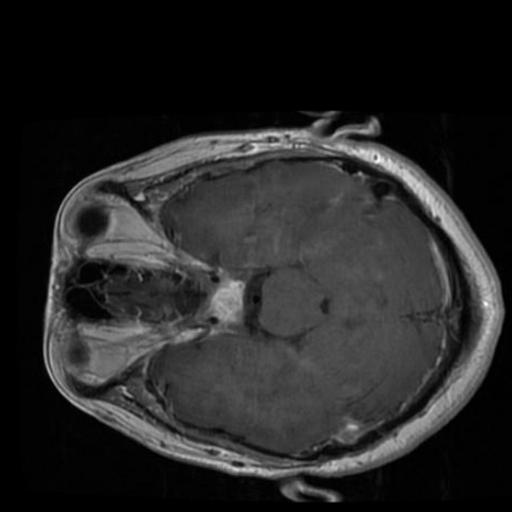

In [8]:
dataset["test"][3]["image"].show()

In [9]:
base_assistant_message = test_instance_base.chat_v1(messages, dataset["test"][-9]["image"])

print(f"Baseline assistant message:{base_assistant_message}")

Generated Description: 

Based on the image provided, the most likely type of brain cancer is **A: brain glioma**.

Here's why:

*   **Appearance:** The image shows a well-defined, round, bright (hyperintense) lesion within the brain parenchyma. This appearance is characteristic of a glioma.
*   **Location:** Gliomas are often found in the cerebral hemispheres, particularly in the frontal, parietal, temporal, or occipital lobes.
*   **Other options:** While the image could potentially represent a meningioma (B) or other brain tumor (C), the specific appearance of the lesion makes glioma the most probable diagnosis.

It's important to note that this is a preliminary assessment based on a single image. A definitive diagnosis requires a comprehensive review of the entire MRI series, clinical history, and potentially additional imaging modalities.

Baseline assistant message:

Based on the image provided, the most likely type of brain cancer is **A: brain glioma**.

Here's why:

*   **Appe

## Test the fine-tuned model


In [10]:
config_medgemma_4b_it_brain_mri.model_folder_bmri_ft_full

'/workspace/meda-main/models/medgemma-4b-it-nct-brain-mri-merged'

In [12]:
test_instance_peft = test_medgemma_4b_it_brain_mri(
    model_id="peft",
    model_folder=config_medgemma_4b_it_brain_mri.model_folder_bmri_ft_full,
    model_kwargs=config_medgemma_4b_it_brain_mri.model_kwargs,
    max_new_tokens=500
)
messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_brain_mri.prompt_template["system_message"],
        user_prompt=config_medgemma_4b_it_brain_mri.prompt_template["user_prompt"])
print(f"System Message:{config_medgemma_4b_it_brain_mri.prompt_template['system_message']}")
print(f"User Message:{config_medgemma_4b_it_brain_mri.prompt_template['user_prompt']}")
print(f"True finding:{config_medgemma_4b_it_brain_mri.condition_findings[dataset['test'][3]['label']]}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it-nct-brain-mri-merged
System Message:You are a medical AI expert analyzing brain MRI images.
User Message:What is the most likely type of brain cancer shown in the MRI image? 
 A: brain glioma
B: brain menin
C: brain tumor
True finding:C: brain tumor


In [13]:
ft_assistant_message = test_instance_peft.chat_v1(messages, dataset["test"][3]["image"])
print(f"Fine-tuned assistant message:{ft_assistant_message}")

Generated Description: 
C: brain tumor
Fine-tuned assistant message:
C: brain tumor


## Test the augmented summary agent 

In [15]:
augmented_user_prompt = (config_medgemma_4b_it_brain_mri.prompt_template["user_prompt"]
                             + f"\nIn your answer, please consider that a fine-tuned model ML model on brain MRI data"
                               f"\n does predict the label **{ft_assistant_message}**  in this case. "
                               f"\nProvide a detailed explanation for your diagnosis.")
    
augmented_messages = make_prompt_without_image(
        system_message=config_medgemma_4b_it_brain_mri.prompt_template["system_message"],
        user_prompt=augmented_user_prompt)
# print(f"Augmented messages:{augmented_messages}")
print(f"Augmented user prompt:{augmented_user_prompt}")


Augmented user prompt:What is the most likely type of brain cancer shown in the MRI image? 
 A: brain glioma
B: brain menin
C: brain tumor
In your answer, please consider that a fine-tuned model ML model on brain MRI data
 does predict the label **
C: brain tumor**  in this case. 
Provide a detailed explanation for your diagnosis.


In [16]:
# augmented_assistant_message = test_instance_base.chat(augmented_messages)
augmented_assistant_message = test_instance_base.chat_v1(augmented_messages, dataset["test"][-6]["image"])

print(f"Augmented-tuned assistant message:{augmented_assistant_message}")

Generated Description: 

Based on the provided MRI image, the most likely diagnosis is **C: brain tumor**.

Here's a detailed explanation:

*   **Image Characteristics:** The image shows a cross-sectional view of the brain. The brain tissue appears relatively normal in terms of its overall structure and signal intensity. However, there is a noticeable abnormality present.

*   **Abnormality:** There is a distinct, well-defined lesion within the brain tissue. The lesion appears as a brighter area compared to the surrounding brain tissue. This suggests a mass or abnormal growth.

*   **Potential Types of Brain Tumors:** Given the characteristics of the lesion, several types of brain tumors could be considered. These include:

    *   **Gliomas:** These are tumors that arise from glial cells, which are the supporting cells of the brain. They can be benign or malignant.
    *   **Meningiomas:** These tumors arise from the meninges, the membranes that surround the brain and spinal cord.
   

In [25]:
## Evaluation

In [18]:
import gc
import torch
del test_instance_peft, test_instant_base
gc.collect()
torch.cuda.empty_cache()

In [2]:
from evaluate_medgemma_4b_it_brain_mri import evaluate_medgemma_4b_it_brain_mri
import config.config_medgemma_4b_it_brain_mri as config_medgemma_4b_it_brain_mri
from utils.fetch_data import load_data_brain_mri

model_kwargs = config_medgemma_4b_it_brain_mri.model_kwargs
evaluator = evaluate_medgemma_4b_it_brain_mri(
    model_id=config_medgemma_4b_it_brain_mri.base_model_id,
    model_folder=config_medgemma_4b_it_brain_mri.model_folder_base,
    model_kwargs=model_kwargs,
    max_new_tokens=250
)

dataset = load_data_brain_mri(test_size=0.05, val_size=0.05, max_examples=None)
dataset_test = dataset["test"]
#dataset_test = dataset_test.select(list(range(10)) + list(range(len(dataset_test)-10, len(dataset_test), 1)))
accuracy_baseline, f1_baseline = evaluator.evaluate(dataset_test, batch_size=4)

print(f"Base Model Evaluation - Accuracy: {accuracy_baseline}, F1 Score: {f1_baseline}")

import gc
import torch
del evaluator
gc.collect()
torch.clear_autocast_cache()



Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it


Resolving data files:   0%|          | 0/6057 [00:00<?, ?it/s]

Dataset structure
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6056
    })
})
Dataset structure after splitting
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5450
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 303
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 303
    })
})
Accuracy: 0.35973597359735976)
F1 Metric: 0.19034573360248647)
Base Model Evaluation - Accuracy: 0.35973597359735976, F1 Score: 0.19034573360248647


In [3]:
evaluator = evaluate_medgemma_4b_it_brain_mri(
    model_id="peft",
    model_folder=config_medgemma_4b_it_brain_mri.model_folder_bmri_ft_full,
    model_kwargs=model_kwargs,
    max_new_tokens=250
)

accuracy_ft, f1_ft = evaluator.evaluate(dataset_test, batch_size=4)

print(f"Fine tuned Model Evaluation - Accuracy: {accuracy_ft}, F1 Score: {f1_ft}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and processor loaded from /workspace/meda-main/models/medgemma-4b-it-nct-brain-mri-merged
Accuracy: 0.9834983498349835)
F1 Metric: 0.9834287971183558)
Fine tuned Model Evaluation - Accuracy: 0.9834983498349835, F1 Score: 0.9834287971183558


In [4]:
del evaluator
gc.collect()
torch.clear_autocast_cache()